# Analyses of brain diseases in TMS dataset

In [1]:
%load_ext lab_black

import matplotlib
import submitit
from os.path import join
import glob
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scdrs

In [2]:
DATA_ROOT_DIR = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
URL_SUPP_TABLE = "https://www.dropbox.com/s/k4tkz981t4x1km5/supp-tables.xlsx?dl=1"

In [3]:
file_list = glob.glob(
    join(
        DATA_ROOT_DIR,
        "tabula_muris_senis/tabula-muris-senis-facs-processed-official-annotations-*",
    )
)
tissue_list = [f.split("annotations-")[-1].split(".")[0] for f in file_list]


df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

dict_trait_code = {
    row["Trait_Identifier"]: row["Code"] for _, row in df_trait_info.iterrows()
}

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

trait_list = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "PASS_BIP_Mullins2021",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
]

In [4]:
SCORE_DIR = join(
    DATA_ROOT_DIR, "score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore"
)
adata = sc.read_h5ad(
    join(
        DATA_ROOT_DIR,
        f"tabula_muris_senis/tabula-muris-senis-facs-processed-official-annotations-Brain_Non-Myeloid.h5ad",
    )
)

for trait in trait_list:
    df_score = pd.read_csv(join(SCORE_DIR, f"{trait}.score.gz"), sep="\t", index_col=0)
    adata.obs[trait] = df_score["zscore"].reindex(adata.obs.index)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


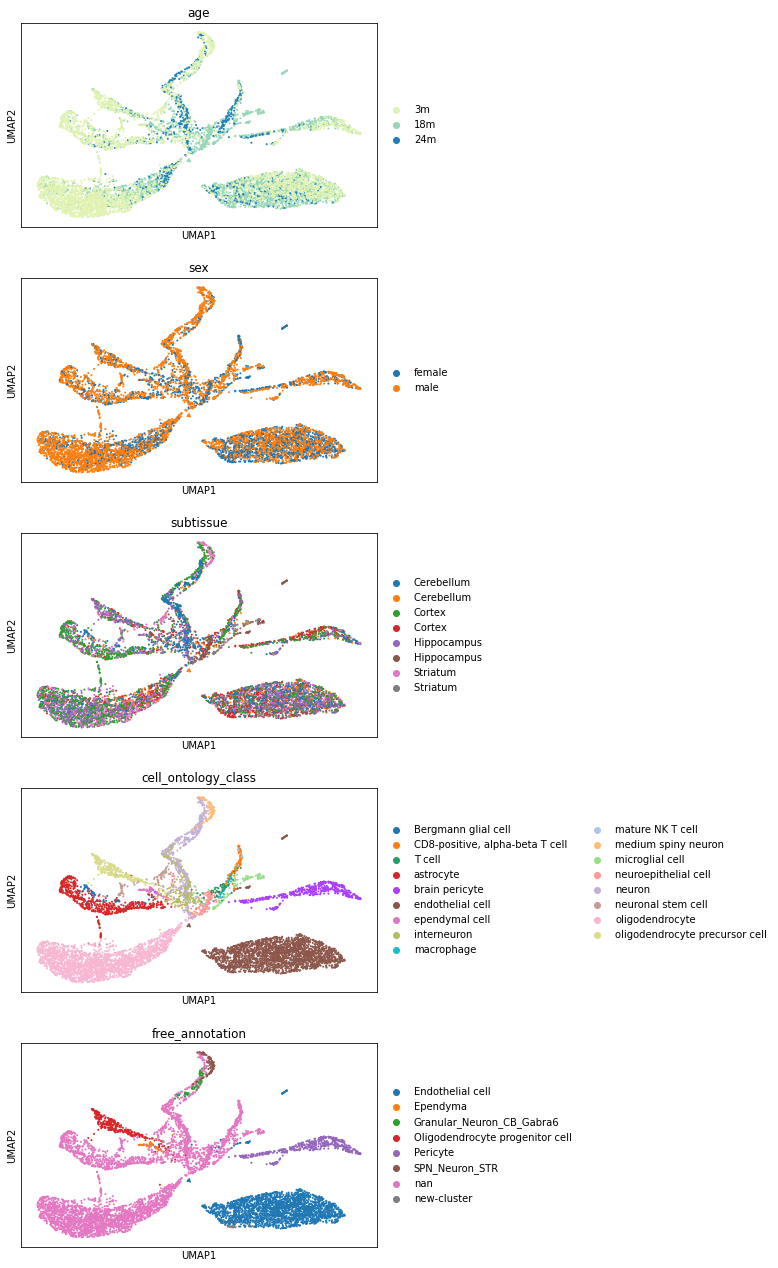

In [5]:
sc.pl.umap(
    adata,
    color=["age", "sex", "subtissue", "cell_ontology_class", "free_annotation"],
    ncols=1,
)

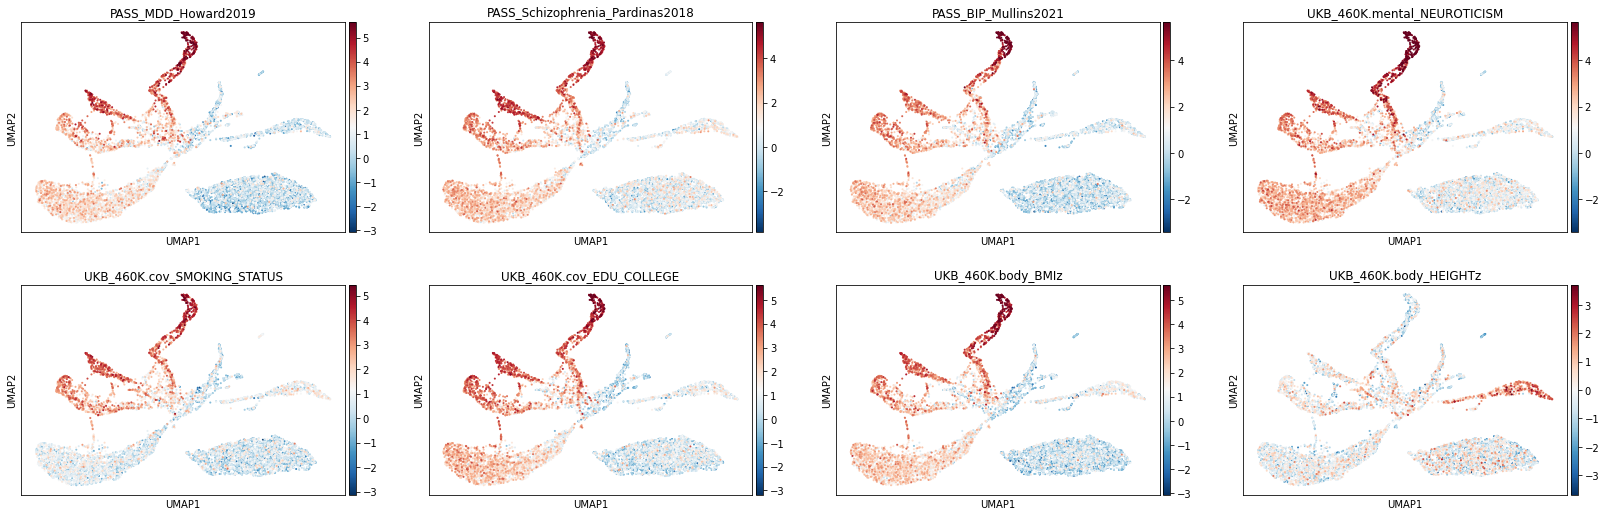

In [6]:
sc.pl.umap(adata, color=trait_list, cmap="RdBu_r")

In [7]:
adata_neuron = adata[adata.obs.cell_ontology_class == "neuron"].copy()
adata_neuron.obs["subtissue"] = adata_neuron.obs.subtissue.apply(lambda x: x.strip())

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


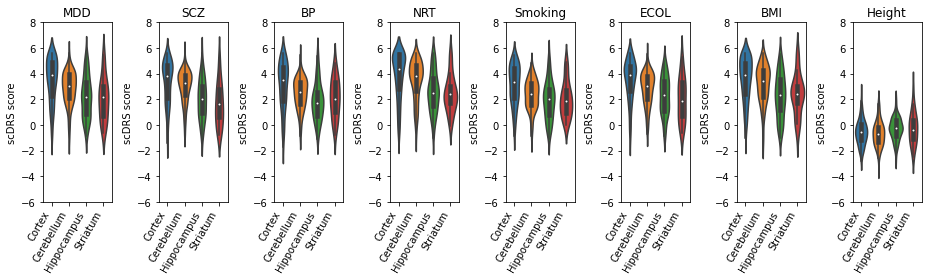

In [8]:
fig, ax = plt.subplots(ncols=len(trait_list), figsize=(13, 4))
for i, trait in enumerate(trait_list):
    df = adata_neuron.obs[["subtissue", trait]]
    g = sns.violinplot(x=df["subtissue"].values, y=df[trait].values, ax=ax[i])
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right")
    g.set_title(dict_trait_code[trait])
    g.set_ylabel("scDRS score")
    g.set_ylim(-6, 8)
plt.tight_layout()
plt.savefig("results/tms_stratify_subtissue.pdf", bbox_inches="tight")

In [ ]:
dict_df_rls = dict()
for trait in trait_list:
    df_score_full = pd.read_csv(
        join(SCORE_DIR, f"{trait}.full_score.gz"), sep="\t", index_col=0
    )
    dict_df_rls[trait] = scdrs.method.test_gearysc(
        adata=adata_neuron,
        df_full_score=df_score_full.reindex(adata_neuron.obs.index),
        groupby="subtissue",
    )

In [ ]:
def pval2str(p_):
    if p_ > 0.05:
        return ""
    elif p_ > 0.005:
        return "×"
    else:
        return "××"


df_pval = pd.DataFrame(
    {dict_trait_code[trait]: dict_df_rls[trait]["pval"] for trait in trait_list}
).T
df_zscore = pd.DataFrame(
    {dict_trait_code[trait]: dict_df_rls[trait]["zsc"] for trait in trait_list}
).T
df_pval = df_pval[["Cerebellum", "Cortex", "Hippocampus", "Striatum"]]
df_zscore = df_zscore[["Cerebellum", "Cortex", "Hippocampus", "Striatum"]]

In [ ]:
fig, ax = plt.subplots(figsize=(1.5, 1.5))
h = sns.heatmap(
    df_zscore,
    annot=df_pval.applymap(pval2str),
    linewidths=0.2,
    linecolor="gray",
    fmt="s",
    cmap="RdBu_r",
    center=0,
    annot_kws={"size": 6},
    xticklabels=True,
    yticklabels=True,
)
h.set_xticklabels(h.get_xticklabels(), rotation=45, ha="right", fontsize=8)
h.set_yticklabels(h.get_yticklabels(), fontsize=8)

h.set_title("Heterogeneity level within sub-tissue \n (TMS FACS)", fontsize=8)
plt.savefig("results/tms_subtissue_hetero.pdf", bbox_inches="tight")